# An Analysis of Lending Club Loan Data

Requirements: wget, unzip, pandas, numpy, sklearn, matplotlib

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import os.path

In [123]:
%matplotlib inline

In [124]:
extraneous_cols = ["out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
				   "collection_recovery_fee", "next_pymnt_d", "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d", "acc_now_delinq",
				   "sub_grade", "issue_d", "initial_list_status", "loan_amnt", "funded_amnt_inv", "emp_title", "pymnt_plan", "zip_code", "title",
                   "addr_state", "earliest_cr_line", "loan_status", "hardship_flag", "application_type", "installment"]

important_cols = ["annual_inc", "verification_status", "term", "home_ownership", "emp_length",
				  "funded_amnt", "int_rate"]

data_files = ["LoanStats_2016Q1.csv",
              "LoanStats_2016Q2.csv",
              "LoanStats_2016Q3.csv",
              "LoanStats_2016Q4.csv",
              "LoanStats_2017Q1.csv"]

We need to get the data files, which are in zipped csv format, from the Lending Club website. We can get them with `wget` and unzip them using Terminal's `unzip` into a data directory.

In [125]:
for filename in data_files:
    if not os.path.isfile(("data/" + filename)):
        url = "https://resources.lendingclub.com/" + filename + ".zip"
        final_relative_filepath = "data/" + filename + ".zip"
        
        !wget -P data/ $url
        !unzip $final_relative_filepath -d data/
        !rm $final_relative_filepath

Each data file has a header that starts with "Notes offered" that we need to get rid of (it has no value to us). We open each data file, check if it has the header, remove it if it does, and then load the file into a dataframe.

In [126]:
dfs = []
for file in ["data/" + filename for filename in data_files]:
    with open(file, "r") as f:
        first_row = next(f)
        # check if "Notes offered" header is present
        if first_row.startswith("Notes offered"):
            # remove top header related to "Notes offered" from CSV file
            with open(file, "r") as original, open((file + "1"), "w") as updated:
                next(original)
                for line in original:
                    updated.write(line)
            os.remove(file)
            os.rename((file + "1"), file)

    # low_memory option gets rid of annoying warning
    # don't include extraneous_cols
    dfs.append(pd.read_csv(file, low_memory = False, usecols = lambda col : col not in extraneous_cols))
lc = pd.concat(dfs)

Concatenating the dataframes leads to duplicated indices. We can resolve this with `reset_index()`.

In [127]:
lc.reset_index(drop = True, inplace = True)

We want to drop any columns where all the values in the column are identical, since these columns do not give us any useful information.

In [128]:
nunique = lc.apply(pd.Series.nunique) # create Series giving the number of unique values in each column
lc.drop(nunique[nunique <= 1].index, axis=1, inplace=True)

We also want to drop columns that have a lot of missing data. If a column is missing 50% of more of its data, we drop it.

In [129]:
coverage = lc.apply(lambda col : col.isnull().sum() / len(col))
lc.drop(coverage[coverage >= 0.5].index, axis=1, inplace=True)

We defined a subset of "important columns" above. We want to drop rows where the data from any of these important columns is missing.

In [130]:
lc = lc.dropna(how = "any", subset = important_cols)

In order to make predictions on this data or analyze it, it needs to be in numeric form. Let's check which columns do not have numerical data.

In [131]:
lc.loc[:5, lc.dtypes == object]

,term,int_rate,grade,emp_length,home_ownership,verification_status,purpose,revol_util
0,60 months,7.39%,A,10+ years,RENT,Not Verified,credit_card,10.5%
1,60 months,7.89%,A,5 years,MORTGAGE,Not Verified,debt_consolidation,10.3%
2,36 months,10.75%,B,10+ years,RENT,Verified,debt_consolidation,53.1%
3,36 months,13.67%,C,< 1 year,RENT,Source Verified,debt_consolidation,38.2%
4,36 months,11.47%,B,6 years,OWN,Source Verified,credit_card,58.2%
5,36 months,5.32%,A,10+ years,RENT,Source Verified,debt_consolidation,30.8%


Interest rate is encoded as strings with '%' signs at the end. We need to convert these values to floats.

In [132]:
# convert int rate string to float
lc["int_rate"] = pd.Series(lc["int_rate"]).str.replace("%", "").astype(float)

Same for the "revol_util" column. Let's do the same thing.

In [133]:
lc["revol_util"] = pd.Series(lc["revol_util"]).str.replace("%", "").astype(float)

We also need to convert term to numerical values (either 36 or 60).

In [134]:
lc["term"] = lc["term"].replace("[^0-9]+", "", regex=True).fillna(0).astype(int)

Let's see what's left.

In [135]:
lc.loc[:5, lc.dtypes == object]

,grade,emp_length,home_ownership,verification_status,purpose
0,A,10+ years,RENT,Not Verified,credit_card
1,A,5 years,MORTGAGE,Not Verified,debt_consolidation
2,B,10+ years,RENT,Verified,debt_consolidation
3,C,< 1 year,RENT,Source Verified,debt_consolidation
4,B,6 years,OWN,Source Verified,credit_card
5,A,10+ years,RENT,Source Verified,debt_consolidation


We need to reformat the employment length column. It has some weird "n/a" values, so we replace those with zeros, and then extract the number (of years) from each value.

In [136]:
lc["emp_length"].replace("n/a", "0", inplace=True)
lc["emp_length"] = lc["emp_length"].replace("[^0-9]+", "", regex=True).fillna(0).astype(int)

We need to impute any remaining missing data values. We'll use the median for this.

In [137]:
lc = lc.apply(lambda x: x.fillna(x.median()) if x.dtype.kind in "biufc" else x)

To simplify our analysis, we'll focus on three year loans (which are the vast majority of loans).

In [138]:
print(lc["term"].value_counts())
lc = lc[lc["term"] == 36]

36    395905
60    135281
Name: term, dtype: int64


The debt-to-income ratio column (DTI) also has some very large outliers, as you can see in the boxplot below.

{'boxes': [<matplotlib.lines.Line2D at 0x128ccf4a8>],
 'caps': [<matplotlib.lines.Line2D at 0x128cd8e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e459c748>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1e45a6898>],
 'whiskers': [<matplotlib.lines.Line2D at 0x128ccfe10>,
  <matplotlib.lines.Line2D at 0x128ccffd0>]}

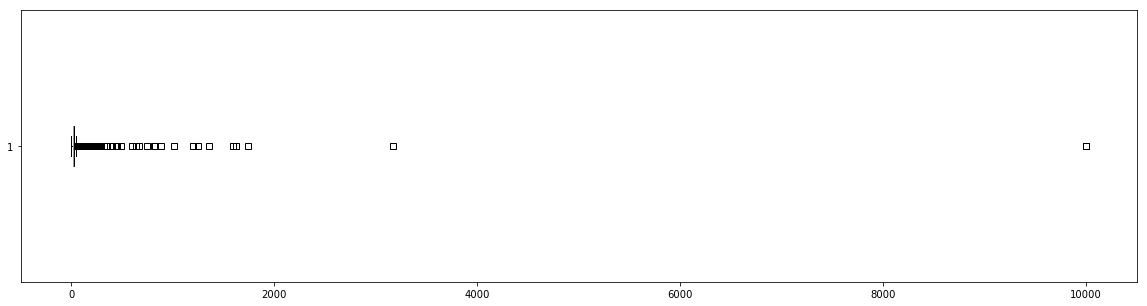

In [139]:
plt.figure(figsize=(20, 5))
plt.boxplot(lc["dti"].values, 0, 's', 0)

Let's analyze these cases in more detail.

In [140]:
lc.loc[lc["dti"] > 9000, :][:5]

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
405,2500.0,36,9.16,B,0,MORTGAGE,0.0,Source Verified,credit_card,9999.0,...,0.0,1.0,100.0,100.0,0.0,0.0,25107.0,16439.0,2700.0,17307.0
2019,12000.0,36,11.99,C,0,MORTGAGE,0.0,Not Verified,debt_consolidation,9999.0,...,0.0,3.0,100.0,66.7,0.0,0.0,126771.0,108679.0,2500.0,112671.0
5183,15000.0,36,9.16,B,0,MORTGAGE,0.0,Not Verified,credit_card,9999.0,...,0.0,2.0,100.0,33.3,2.0,0.0,60405.0,37390.0,22600.0,35505.0
11013,9100.0,36,12.99,C,0,RENT,0.0,Not Verified,debt_consolidation,9999.0,...,0.0,3.0,77.3,20.0,0.0,0.0,49362.0,43140.0,8300.0,39562.0
16355,5000.0,36,9.16,B,0,RENT,0.0,Not Verified,debt_consolidation,9999.0,...,0.0,0.0,83.3,100.0,0.0,0.0,33308.0,16789.0,1000.0,24108.0


One point stands out. The annual income for all of these borrowers is zero, which is why their DTIs are infinitely high (Lending Club has equated a divide-by-zero DTI with the value 9999). We should filter out such outliers. In fact, we'll filter out any loan where the DTI is above 100, since this is abnormal and the data is likely questionable.

In [141]:
lc = lc[lc["dti"] < 100]

Let's look to see if there are any interesting correlations between different data fields.

In [142]:
cor = lc.corr()
cor.loc[:, :] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.8) | (cor < -0.8)]

total_rev_hi_lim            revol_bal            0.830151
acc_open_past_24mths        open_rv_24m          0.851966
avg_cur_bal                 tot_cur_bal          0.835052
bc_util                     revol_util           0.851376
num_actv_rev_tl             num_actv_bc_tl       0.817753
num_bc_sats                 num_actv_bc_tl       0.844293
num_op_rev_tl               open_acc             0.833218
                            num_actv_rev_tl      0.801890
num_rev_accts               num_bc_tl            0.836718
                            num_op_rev_tl        0.805217
num_rev_tl_bal_gt_0         num_actv_bc_tl       0.807605
                            num_actv_rev_tl      0.979836
                            num_op_rev_tl        0.806097
num_sats                    open_acc             0.998746
                            num_op_rev_tl        0.832032
num_tl_op_past_12m          open_rv_12m          0.847976
percent_bc_gt_75            bc_util              0.841692
tot_hi_cred_li

Let's plot some of the ones with the highest correlations.

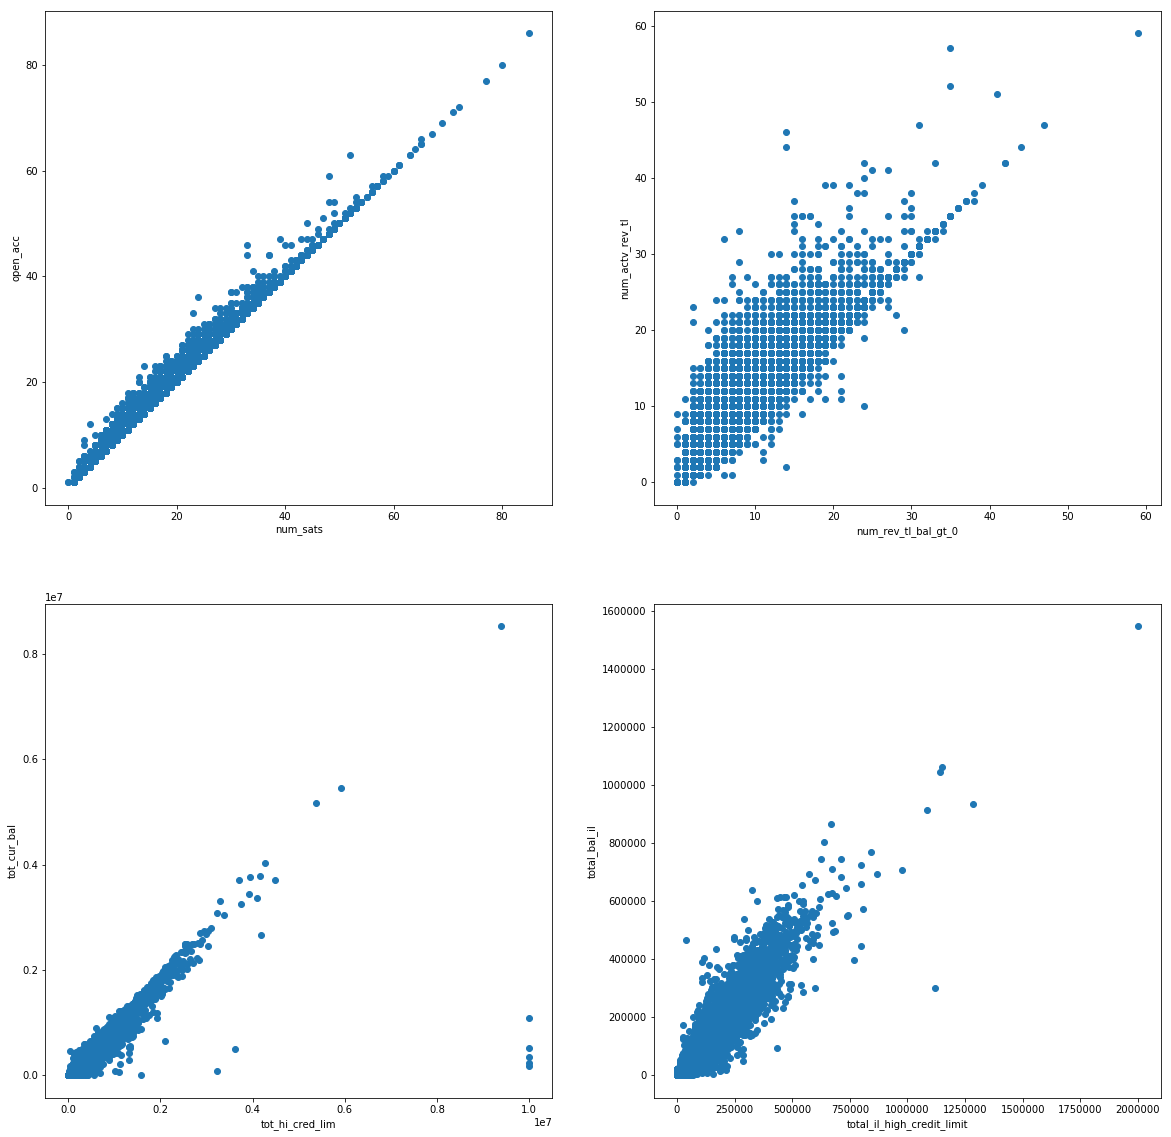

In [143]:
def plot_scatter (ax, series1, series2, var1, var2):
    ax.scatter(series1, series2)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

fig = plt.figure(1, figsize=(20,20))

ax = fig.add_subplot(221)
plot_scatter(ax, lc["num_sats"].values, lc["open_acc"].values, "num_sats", "open_acc")

ax2 = fig.add_subplot(222)
plot_scatter(ax2, lc["num_rev_tl_bal_gt_0"].values, lc["num_actv_rev_tl"].values, "num_rev_tl_bal_gt_0", "num_actv_rev_tl")

ax3 = fig.add_subplot(223)
plot_scatter(ax3, lc["tot_hi_cred_lim"].values, lc["tot_cur_bal"].values, "tot_hi_cred_lim", "tot_cur_bal")

ax4 = fig.add_subplot(224)
plot_scatter(ax4, lc["total_il_high_credit_limit"].values, lc["total_bal_il"].values, "total_il_high_credit_limit", "total_bal_il")

None of these scatter plots are linear enough that I'd feel comfortable deleting columns for feature reduction. Useful information would likely be lost.

Looking at the dataframe again, home ownership, verification status, and loan purpose are all categorically encoded (we'll worry about grade later). Let's dummy encode these variables.

In [144]:
lc.loc[:5, lc.dtypes == object]

,grade,home_ownership,verification_status,purpose
2,B,RENT,Verified,debt_consolidation
3,C,RENT,Source Verified,debt_consolidation
4,B,OWN,Source Verified,credit_card
5,A,RENT,Source Verified,debt_consolidation


In [145]:
#create dummy variables for categorical variables
lc = pd.get_dummies(lc, columns=["home_ownership", "verification_status", "purpose"])

Let's take a quick look at our data, post data-munging.

In [146]:
print("Dimensions: ", lc.shape)
lc.head(5)

Dimensions:  (395722, 89)


,funded_amnt,term,int_rate,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
2,35000.0,36,10.75,B,10,70000.0,17.86,0.0,0.0,31.0,...,0,0,0,0,0,0,0,0,0,0
3,8825.0,36,13.67,C,1,32000.0,21.49,0.0,0.0,45.0,...,0,0,0,0,0,0,0,0,0,0
4,10000.0,36,11.47,B,6,33000.0,21.45,0.0,0.0,30.0,...,0,0,0,0,0,0,0,0,0,0
5,14000.0,36,5.32,A,10,240000.0,12.31,1.0,0.0,12.0,...,0,0,0,0,0,0,0,0,0,0
6,16000.0,36,12.99,C,1,50000.0,38.32,0.0,0.0,50.0,...,0,0,0,0,0,0,0,0,0,0


Now for the fun part! Let's get ready for ML by moving the column we are predicting (interest rate) to the front of the dataframe, and the grade column (which we don't want as an ML feature but still want to work with later) to the second position.

In [147]:
cols = lc.columns.tolist()
cols.insert(0, cols.pop(cols.index("int_rate")))
cols.insert(1, cols.pop(cols.index("grade")))
lc = lc.loc[:, cols]

Now, let's turn this dataframe into a numpy ndarray for ML.

In [148]:
data = lc.values
X = data[:, 2:] # skip the grade column
y = data[:, 0]

Let's train and test a Random Forest Regressor for interest rate prediction.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
rf_tt = RandomForestRegressor(n_estimators = 100, n_jobs = -1)
rf_tt.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_tt.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_tt.score(X_test, y_test)))

Training accuracy: 0.92
Generalization accuracy: 0.46


Let's plot the results below.

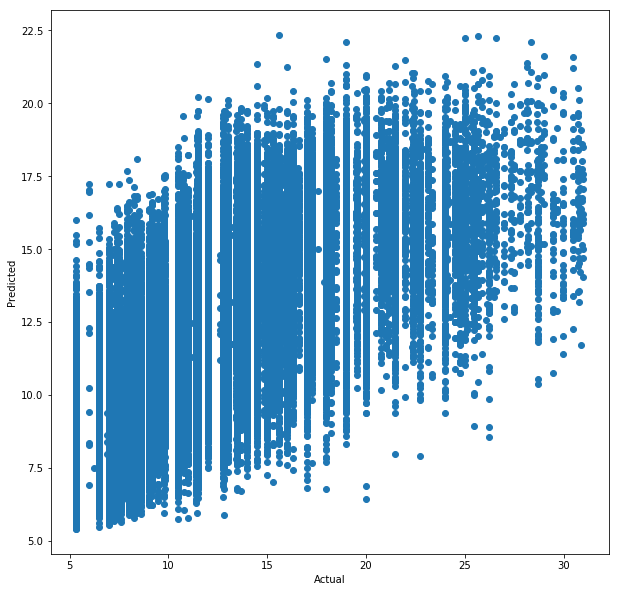

In [160]:
fig = plt.figure(1, figsize=(10, 10))
ax = fig.add_subplot(111)
plot_scatter(ax, y_test, rf_tt.predict(X_test), "Actual", "Predicted")

There is a general linear upward trend, but predictions really are all over the place.

The model had a very high training accuracy but a low generalization accuracy, suggesting that overfitting could be an issue. Let's try cross-validating to see if overfitting is a persistent issue.

In [150]:
rf = RandomForestRegressor(n_estimators=100)
print("Cross-validation scores:\n{}".format(cross_val_score(rf, X, y, cv=5, n_jobs=-1)))

Cross-validation scores:
[ 0.46858406  0.44662838  0.45583588  0.39956075  0.39446228]


It seems as though it is a persistent issue. Let's try reducing the complexity of our model to help with generalization. First, we'll try reducing `max_features` to 1.

In [151]:
rf_lower_max_features = RandomForestRegressor(n_estimators = 100, max_features = 1, n_jobs = -1)
rf_lower_max_features.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_lower_max_features.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_lower_max_features.score(X_test, y_test)))

Training accuracy: 0.91
Generalization accuracy: 0.37


That didn't seem to help. Let's try increasing the minimum number of samples per leaf in the decision trees, which should reduce the amount of branching and complexity.

In [152]:
rf_higher_min_samples_leaf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs = -1)
rf_higher_min_samples_leaf.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf.score(X_test, y_test)))

Training accuracy: 0.70
Generalization accuracy: 0.45


That also didn't seem to help. Let's try one more time, and increase `min_samples_leaf` even more.

In [153]:
rf_higher_min_samples_leaf1 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 20, n_jobs = -1)
rf_higher_min_samples_leaf1.fit(X_train, y_train)
print("Training accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_train, y_train)))
print("Generalization accuracy: {:.2f}".format(rf_higher_min_samples_leaf1.score(X_test, y_test)))

Training accuracy: 0.60
Generalization accuracy: 0.45


That also didn't seem to help. Let's try switching to a neural network. First, we need to scale the data (this is very important for NNs). Scikit-learn has a built-in StandardScaler which we can use.

In [154]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/nihar/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Now, let's train and test a basic NN.

In [ ]:
from sklearn.neural_network import MLPRegressor

initial_nn = MLPRegressor()
initial_nn.fit(X_train_scaled, y_train)
print("Training accuracy: {:.2f}".format(initial_nn.score(X_train_scaled, y_train)))
print("Generalization accuracy: {:.2f}".format(initial_nn.score(X_test_scaled, y_test)))

Let's try increasing the number of hidden layers. Now, we'll create an NN that has two hidden layers with a hundred nodes each.

In [ ]:
nn_more_hidden_layers = MLPRegressor(hidden_layer_sizes = [100, 100])
nn_more_hidden_layers.fit(X_train_scaled, y_train)
print("Training accuracy: {:.2f}".format(nn_more_hidden_layers.score(X_train_scaled, y_train)))
print("Generalization accuracy: {:.2f}".format(nn_more_hidden_layers.score(X_test_scaled, y_test)))

It seems that it's fairly difficult to predict the interest rate Lending Club will assign to a loan, especially after they redacted a large portion of loan data including FICO scores (which are the primary component of their grading model). The best model we created has an R^2 score of only 0.5.

Still, let's look at the importance of different features in the Random Forest model and see if we can gain any insight from it.

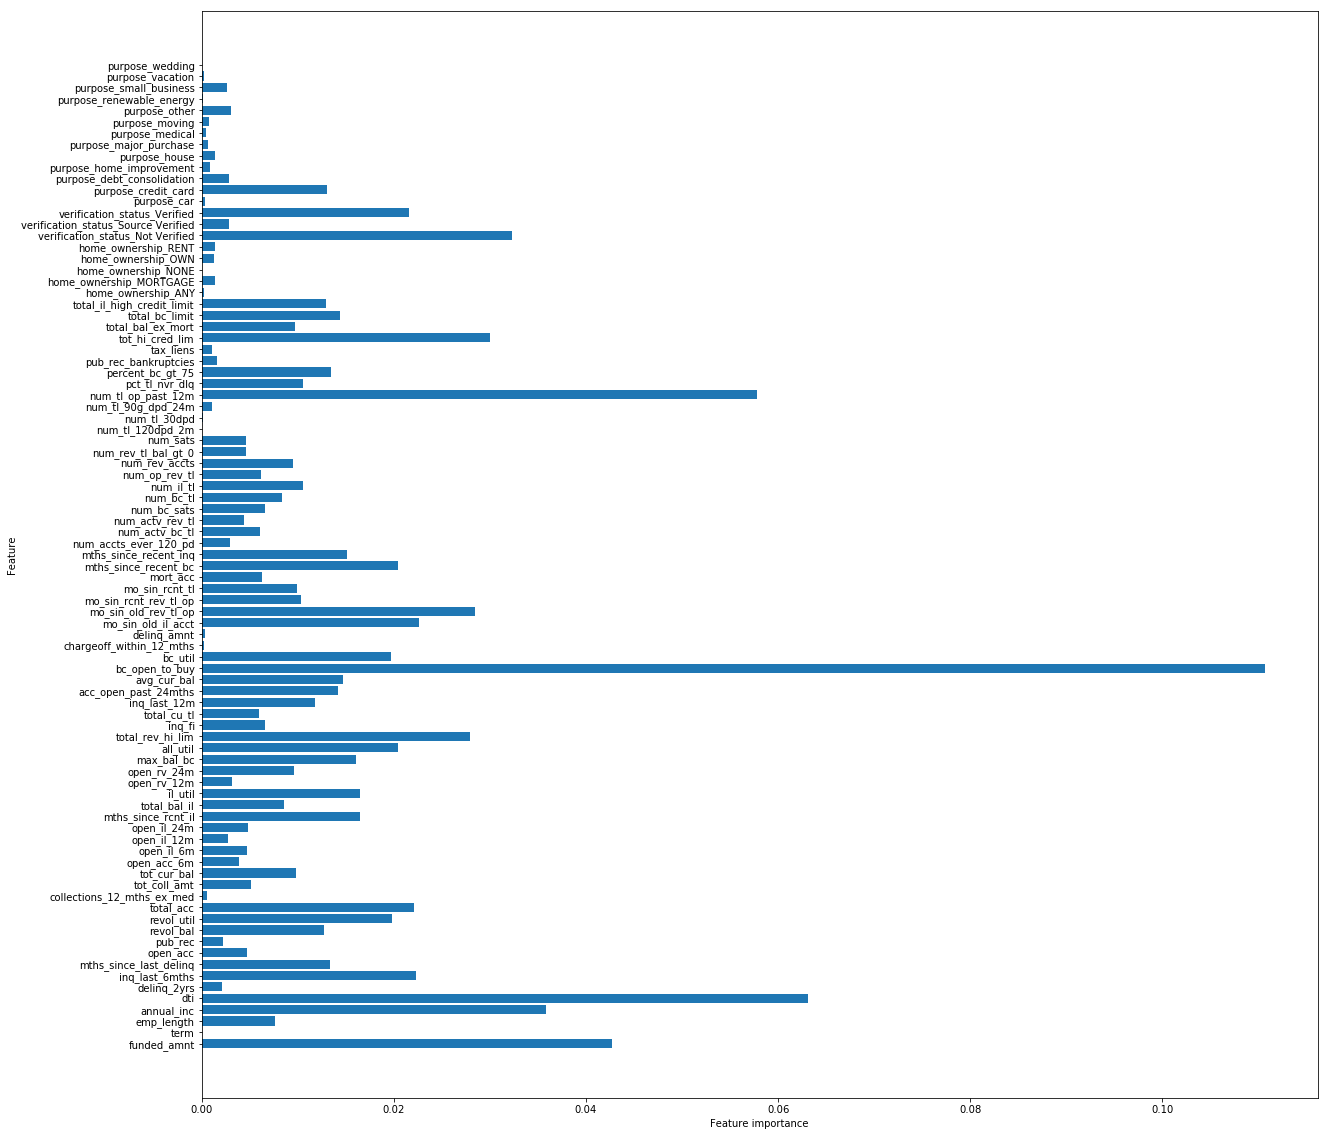

In [158]:
def plot_feature_importances (model):
    n_features = len(lc.columns.tolist()[2:])
    plt.figure(figsize=(20, 20))
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), lc.columns.tolist()[2:])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf_tt)

It looks like "bc_open_to_buy", which is the total amount open to buy on revolving bankcards, is the most important feature by far. DTI is also important (expected), and so is funded_amnt (which is also expected). Let's look at these relationships visually.

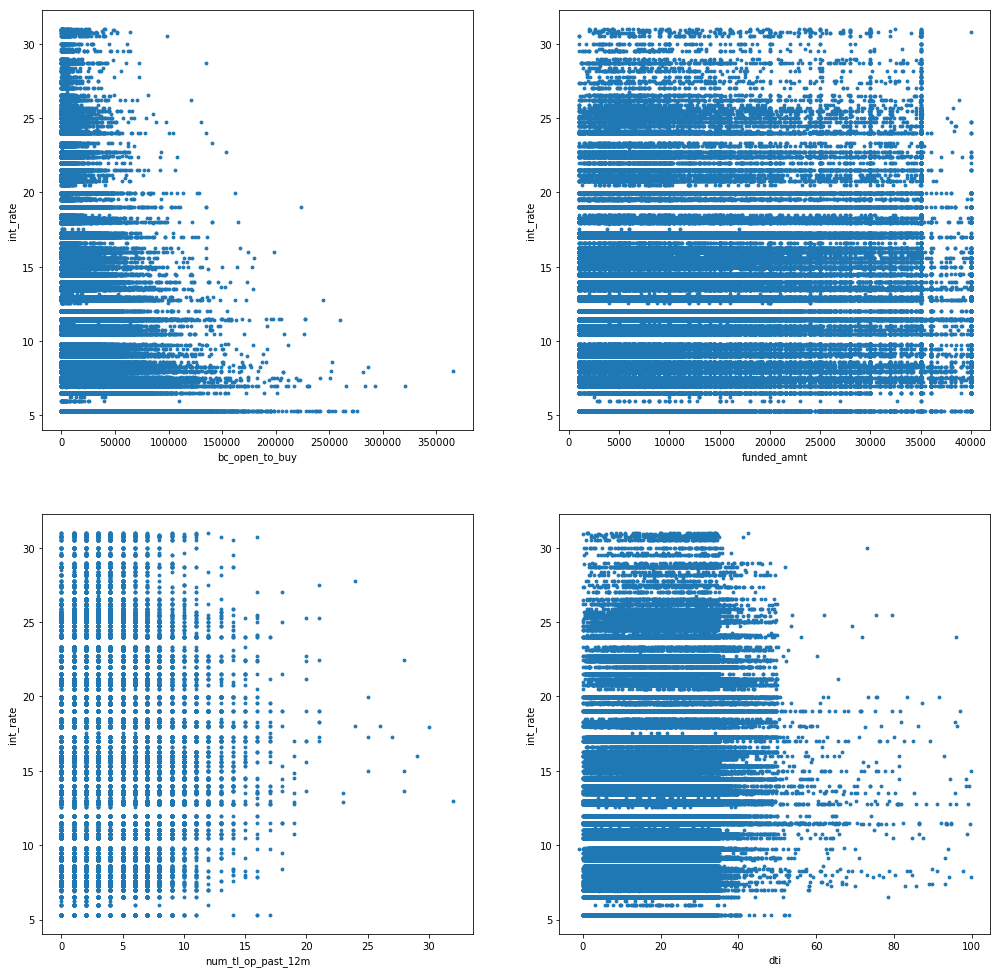

In [22]:
def plot_scatter (ax, variable):
    ax.scatter(lc[variable].values, lc["int_rate"].values, s=8)
    ax.set_xlabel(variable)
    ax.set_ylabel("int_rate")

fig = plt.figure(1, figsize=(20,20))

ax = fig.add_subplot(221)
plot_scatter(ax, "bc_open_to_buy")

ax2 = fig.add_subplot(222)
plot_scatter(ax2, "funded_amnt")

ax3 = fig.add_subplot(223)
plot_scatter(ax3, "num_tl_op_past_12m")

ax4 = fig.add_subplot(224)
plot_scatter(ax4, "dti")

The relationship between "bc_open_to_buy" and interest rate is pretty clear. There is a general trend that the more a person has left to buy on revolving bankcards, the lower their interest rate will be. This makes sense, since a higher bankcard limit indicates better credit, and lower usage of the bankcard (which would leave more left to buy), also indicates good credit habits. The relationships with the other three variables are visually less clear, although some general trends are visible. Remember, the Random Forest can pick up on relationships that are the result of interactions between multiple features, and may not be completely visible in one of these graphs.

Let's also look at some of these features in boxplots across different loan grades.

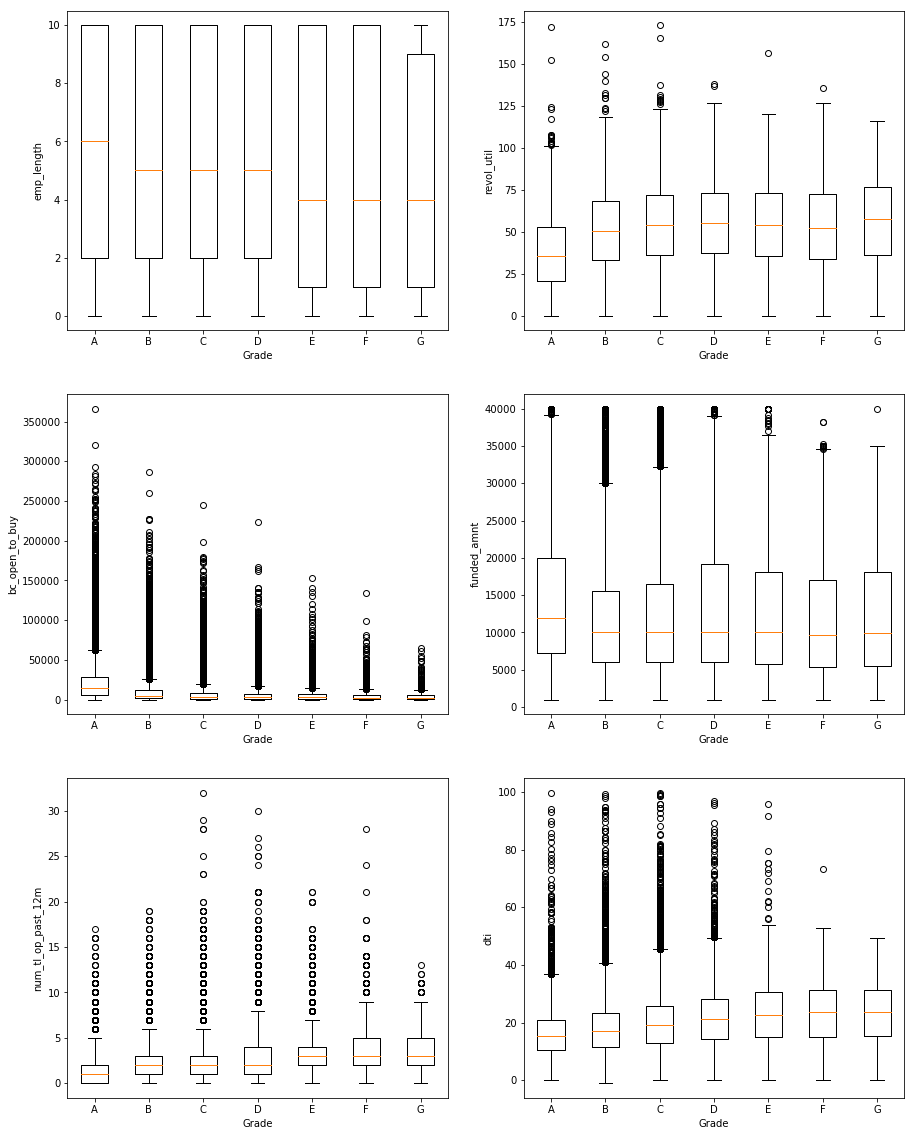

In [23]:
def plot_boxplots (ax, variable):
    ax.boxplot([lc[lc["grade"] == grade][variable].values for grade in sorted(lc["grade"].unique())])
    ax.set_xticklabels(sorted(lc["grade"].unique()))
    ax.set_xlabel("Grade")
    ax.set_ylabel(variable)

fig = plt.figure(2, figsize=(15,20))

ax = fig.add_subplot(321)
plot_boxplots(ax, "emp_length")

ax2 = fig.add_subplot(322)
plot_boxplots(ax2, "revol_util")

ax3 = fig.add_subplot(323)
plot_boxplots(ax3, "bc_open_to_buy")

ax4 = fig.add_subplot(324)
plot_boxplots(ax4, "funded_amnt")

ax5 = fig.add_subplot(325)
plot_boxplots(ax5, "num_tl_op_past_12m")

ax6 = fig.add_subplot(326)
plot_boxplots(ax6, "dti")

In summary, it seems that as borrower, to minimize your interest rate, you should focus on the following points:

* Lower your outstanding debt and try to raise your income to lower DTI (I know, easier said than done).
* Don't open many credit accounts in the year before applying, since this is associated with higher interest rates.
* Get a high credit limit for your bankcards, but DO NOT actually take out much credit through those bankcards. Leave yourself with a large open to buy balance and a low percent utilization (low revol_util).
* As expected, being employed for a longer time period appears to help slightly with getting lower interest rates.